In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [20]:
n=400
t=np.arange(n)
beta0=100
beta1=2
A=40
p=12
sigma=5

# Génération du bruit
trend = beta0 + beta1 * t
seasonality = A * np.sin(2 * np.pi * t / p)
noise = np.random.normal(0, sigma, n)

# Génération de la série temporelle
sales = trend + seasonality + noise

#cre un DataFrame pandas
dates = pd.date_range(start='2020-01-01', periods=n, freq='M')
data = pd.DataFrame({'Date': dates, 'Sales': sales, 'Trend': trend, 'Seasonality': seasonality, 'Noise': noise})

C:\Users\0000\AppData\Local\Temp\ipykernel_26096\1401895704.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2020-01-01', periods=n, freq='M')


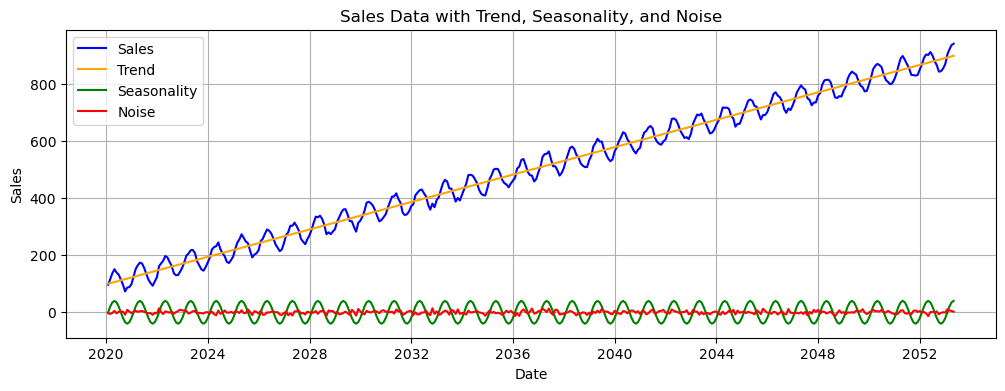

In [21]:
# Visualisation
plt.figure(figsize=(12, 4))
plt.plot(data['Date'], data['Sales'], label='Sales', color='blue')
plt.plot(data['Date'], data['Trend'], label='Trend', color='orange')
plt.plot(data['Date'], data['Seasonality'], label='Seasonality', color='green')
plt.plot(data['Date'], data['Noise'], label='Noise', color='red')
plt.title('Sales Data with Trend, Seasonality, and Noise')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid()
plt.legend()
plt.show()


In [22]:
## Split train/valid
split_time = 250
train = data[:split_time]
valid = data[split_time:]

In [23]:
train.shape

(250, 5)

In [24]:
valid.shape

(150, 5)

## Model naif : yhat{t+1}= y{t}

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Model naif : yhat{t+1}= y{t}
# Prédictions naïves: yhat{t+1} = y{t}
# Pour la validation, on utilise la dernière valeur du train comme première prédiction
# puis on décale les valeurs réelles de valid pour les prédictions suivantes

naive_forecast = np.zeros(len(valid))
naive_forecast[0] = train['Sales'].iloc[-1]  # Première prédiction = dernière valeur du train
naive_forecast[1:] = valid['Sales'].iloc[:-1].values  # Les autres = valeurs précédentes de valid

# Calcul des métriques

mae = mean_absolute_error(valid['Sales'], naive_forecast)
mse = mean_squared_error(valid['Sales'], naive_forecast)
rmse = np.sqrt(mse)
r2 = r2_score(valid['Sales'], naive_forecast)

print("Naive Model Metrics:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")


Naive Model Metrics:
MAE: 13.79
MSE: 266.14
RMSE: 16.31
R²: 0.9680


In [26]:
## Sauvegarder les metrics dans un csv
metrics_df = pd.DataFrame({
    'Model': ['Naive'],
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse],
    'R2': [r2]
})

metrics_df.to_csv('naive_model_metrics.csv', index=False)
print("Metrics saved to 'naive_model_metrics.csv'")


Metrics saved to 'naive_model_metrics.csv'


## Maintenant je fais une regression simple yhat{t+1}= f(y{t})

In [ ]:
train


(250, 5)

In [ ]:
from sklearn.linear_model import LinearRegression

# Préparer les données pour la régression: X = y{t}, y = y{t+1}
X_train = train['Sales'].iloc[:-1].values.reshape(-1, 1)
y_train = train['Sales'].iloc[1:].values

# Entraîner le modèle
model = LinearRegression()
model.fit(X_train, y_train)

# Prédictions sur validation
# Pour la première prédiction, on utilise la dernière valeur du train
lr_forecast = np.zeros(len(valid))
lr_forecast[0] = model.predict([[train['Sales'].iloc[-1]]])[0]

# Pour les prédictions suivantes, on utilise les valeurs réelles de valid
for i in range(1, len(valid)):
    lr_forecast[i] = model.predict([[valid['Sales'].iloc[i-1]]])[0]

# Calcul des métriques
mae_lr = mean_absolute_error(valid['Sales'], lr_forecast)
mse_lr = mean_squared_error(valid['Sales'], lr_forecast)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(valid['Sales'], lr_forecast)

print("Linear Regression Model Metrics:")
print(f"MAE: {mae_lr:.2f}")
print(f"MSE: {mse_lr:.2f}")
print(f"RMSE: {rmse_lr:.2f}")
print(f"R²: {r2_lr:.4f}")
print(f"\nModel coefficients: slope={model.coef_[0]:.4f}, intercept={model.intercept_:.4f}")

Linear Regression Model Metrics:
MAE: 13.95
MSE: 274.77
RMSE: 16.58
R²: 0.9670

Model coefficients: slope=0.9915, intercept=4.8014


In [29]:
## Sauvegarde des metrics dans un csv
metrics = pd.DataFrame({
    'Model': ['Linear Regression'],
    'MAE': [mae_lr],
    'MSE': [mse_lr],
    'RMSE': [rmse_lr],
    'R2': [r2_lr]
})
metrics.to_csv('linear_regression_model_metrics.csv', index=False)

In [34]:
X_train[-1]

array([565.9706976])

In [35]:
y_train[-1]

556.409946793368

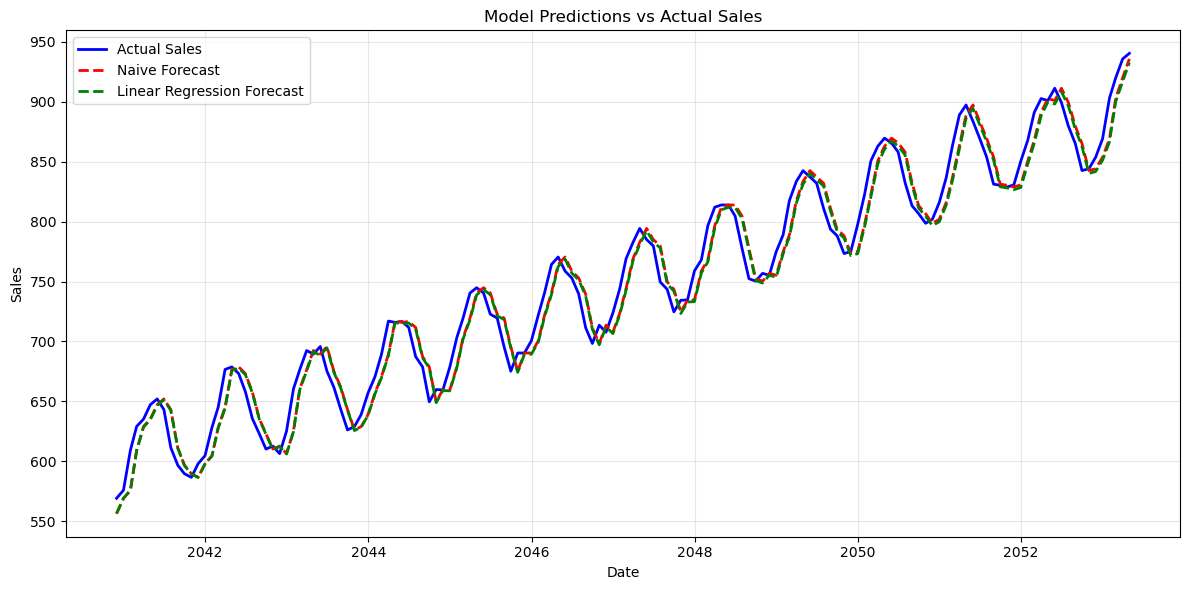

In [38]:
## Ploter les prédictions des deux modèles
plt.figure(figsize=(12, 6))
plt.plot(valid['Date'], valid['Sales'], label='Actual Sales', color='blue', linewidth=2)
plt.plot(valid['Date'], naive_forecast, label='Naive Forecast', color='red', linewidth=2, linestyle='--')
plt.plot(valid['Date'], lr_forecast, label='Linear Regression Forecast', color='green', linewidth=2, linestyle='--')
plt.title('Model Predictions vs Actual Sales')  
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

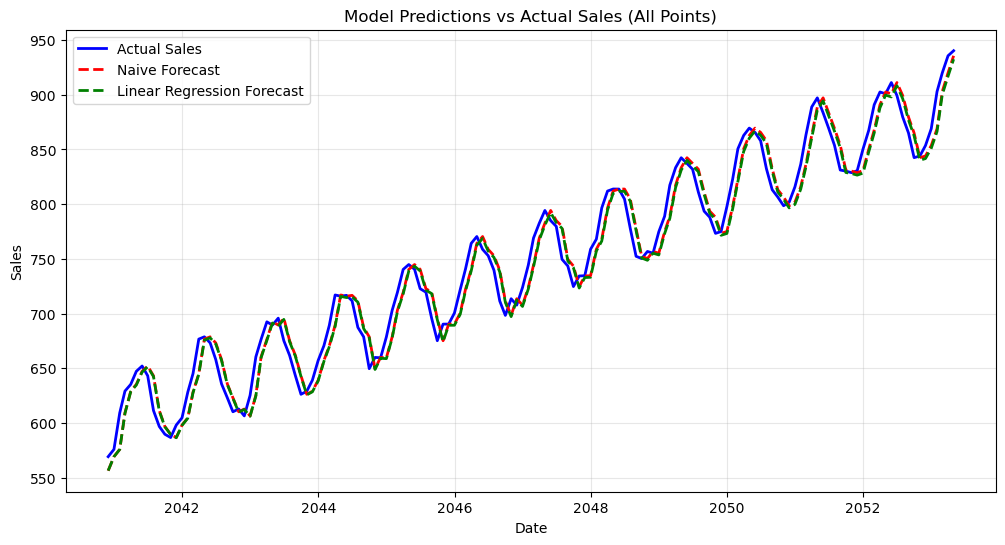

In [41]:
## Zoom sur les valeurs de la validation
plt.figure(figsize=(12, 6))
plt.plot(valid['Date'], valid['Sales'], label='Actual Sales', color='blue', linewidth=2)
plt.plot(valid['Date'], naive_forecast, label='Naive Forecast', color='red', linewidth=2, linestyle='--')
plt.plot(valid['Date'], lr_forecast, label='Linear Regression Forecast', color='green', linewidth=2, linestyle='--')
plt.title('Model Predictions vs Actual Sales (All Points)')
plt.xlabel('Date')
plt.ylabel('Sales') 
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [42]:
## Faire une etude comparative des deux modèles sur la validation
comparison = pd.DataFrame({
    'Date': valid['Date'],
    'Actual Sales': valid['Sales'],
    'Naive Forecast': naive_forecast,
    'Linear Regression Forecast': lr_forecast
})
comparison

,Date,Actual Sales,Naive Forecast,Linear Regression Forecast
250,2040-11-30,569.245110,556.409947,556.488934
251,2040-12-31,575.960617,569.245110,569.215162
252,2041-01-31,609.256501,575.960617,575.873674
253,2041-02-28,629.176996,609.256501,608.886969
254,2041-03-31,635.341567,629.176996,628.638394
...,...,...,...,...
395,2052-12-31,868.976082,853.564504,851.121479
396,2053-01-31,902.919931,868.976082,866.402257
397,2053-02-28,919.925414,902.919931,900.058017
398,2053-03-31,935.619444,919.925414,916.919171


In [46]:
## Faire une etude comparative des deux modèles sur les metrics
metrics_comparison = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'R2'],
    'Naive Model': [mae, mse, rmse, r2],
    'Linear Regression Model': [mae_lr, mse_lr, rmse_lr, r2_lr]
})
print(metrics_comparison)

  Metric  Naive Model  Linear Regression Model
0    MAE    13.788028                13.954116
1    MSE   266.138626               274.772841
2   RMSE    16.313756                16.576273
3     R2     0.968022                 0.966985


In [47]:
from scipy.stats import pearsonr

# Analyse de l'autocorrélation

# Corrélation entre y{t} et y{t+1} sur l'ensemble d'entraînement
corr_lag1, _ = pearsonr(train['Sales'].iloc[:-1], train['Sales'].iloc[1:])
print(f"Corrélation y{{t}} et y{{t+1}}: {corr_lag1:.4f}")

# Vérifier les coefficients du modèle LR
print(f"\nModèle LR: y{{t+1}} = {model.coef_[0]:.4f} * y{{t}} + {model.intercept_:.4f}")
print(f"Si le modèle était parfait avec tendance pure: coefficient ≈ 1.0, intercept ≈ 2.0")

# Comparaison des erreurs moyennes
print(f"\nNaive RMSE: {rmse:.2f}")
print(f"LR RMSE: {rmse_lr:.2f}")
print(f"Différence: {rmse_lr - rmse:.2f}")

# Le problème: la régression linéaire devrait être meilleure!
# Possible causes:
# 1. Le modèle LR n'utilise qu'une seule variable (y{t})
# 2. Il ignore la saisonnalité
# 3. Il ignore d'autres lags potentiellement utiles

Corrélation y{t} et y{t+1}: 0.9934

Modèle LR: y{t+1} = 0.9915 * y{t} + 4.8014
Si le modèle était parfait avec tendance pure: coefficient ≈ 1.0, intercept ≈ 2.0

Naive RMSE: 16.31
LR RMSE: 16.58
Différence: 0.26


## Ajout de window

In [65]:
## Je veux ajouter des windows donc je veux une fonction pour fenetrer la data
def create_windowed_data(series, window_size):
    X = []
    y = []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)

def windowed_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def windowed_dataset_valid(series, window_size, batch_size=32):
    dataset_valid = tf.data.Dataset.from_tensor_slices(series)
    dataset_valid = dataset_valid.window(window_size + 1, shift=1, drop_remainder=True)
    dataset_valid = dataset_valid.flat_map(lambda window: window.batch(window_size + 1))
    dataset_valid = dataset_valid.map(lambda window: (window[:-1], window[-1]))
    dataset_valid = dataset_valid.batch(batch_size).prefetch(1)
    return dataset_valid

In [51]:
## creer des fenêtres
window_size = 12  # Par exemple, utiliser les 12 derniers mois pour prédire le suivant
X_train_w, y_train_w = create_windowed_data(train['Sales'].values, window_size)
print(X_train_w.shape)

(238, 12)


In [ ]:
## entrainement d'un modèle de régression linéaire avec les fenêtres en utilisant tensorflow.keras (approche neural network pour series temporelles)

model_nn = keras.Sequential([
    keras.layers.Input(shape=(window_size,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])
model_nn.compile(optimizer='adam', loss='mse')
model_nn.fit(X_train_w, y_train_w, epochs=50, batch_size=16, verbose=1)




Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 228522.8750
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29665.8066 
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 985.0883 
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1587.8651 
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 583.7652 
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 503.7352 
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 394.6260 
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 332.4217 
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 302.5633 
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 289.5858 
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 258.2958 
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 196.1727 
Epoch 13/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 183.0704  
Epoch 14/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 153.1039 
Epoch 15/50
15/15 ━━━━━━━━━━━━━━━━━━━

In [58]:
## creer une fonction pour les metrics
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {
        'MAE NN': mae,
        'MSE NN': mse,
        'RMSE NN': rmse,
        'R2 NN': r2
    }

# creer une fonction pour creer un csv des metrics
def create_metrics_csv_nn(model_name, mae, mse, rmse, r2, filename):
    metrics_df = pd.DataFrame({
        'Model': [model_name],
        'MAE': [mae],
        'MSE': [mse],
        'RMSE': [rmse],
        'R2': [r2]
    })
    metrics_df.to_csv(filename, index=False)
    print(f"Metrics saved to '{filename}'")

In [54]:
# creer des fenêtres pour la validation
X_valid_w, y_valid_w = create_windowed_data(valid['Sales'].values, window_size)

In [55]:
## Faire des prédictions avec le modèle NN
nn_forecast = model_nn.predict(X_valid_w).flatten()
metrics_nn = calculate_metrics(y_valid_w, nn_forecast)
print("Neural Network Model Metrics:")
for key, value in metrics_nn.items():
    print(f"  {key}: {value}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Neural Network Model Metrics:
  MAE NN: 11.68043052188931
  MSE NN: 172.58646074688036
  RMSE NN: 13.137216628604415
  R2 NN: 0.9760351553911855


In [59]:
## csv des metrics du modèle NN
create_metrics_csv_nn(
    model_name='Neural Network',
    mae=metrics_nn['MAE NN'],
    mse=metrics_nn['MSE NN'],
    rmse=metrics_nn['RMSE NN'],
    r2=metrics_nn['R2 NN'],
    filename='neural_network_model_metrics.csv'
)

Metrics saved to 'neural_network_model_metrics.csv'


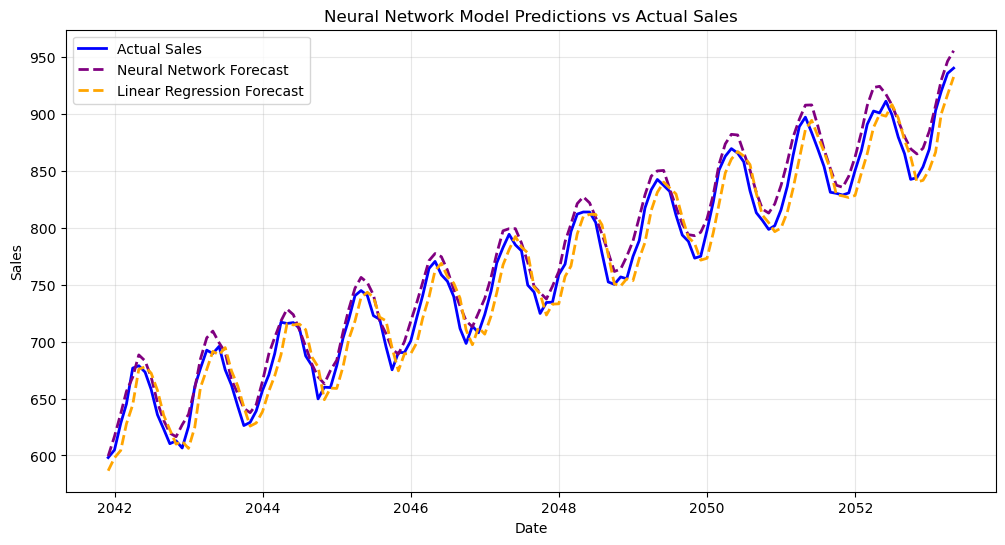

In [62]:
## Visualisation des prédictions du modèle NN
plt.figure(figsize=(12, 6))
plt.plot(valid['Date'][window_size:], y_valid_w, label='Actual Sales', color='blue', linewidth=2)
plt.plot(valid['Date'][window_size:], nn_forecast, label='Neural Network Forecast', color='purple', linewidth=2, linestyle='--')
plt.plot(valid['Date'][window_size:], lr_forecast[window_size:], label='Linear Regression Forecast', color='orange', linewidth=2, linestyle='--')
plt.title('Neural Network Model Predictions vs Actual Sales')   
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [63]:
# Tester différentes tailles de fenêtres
window_sizes = [3, 6, 12, 24, 36, 48]
results = []

for ws in window_sizes:
    print(f"\nTesting window_size = {ws}")
    
    # Créer les fenêtres
    X_train_w, y_train_w = create_windowed_data(train['Sales'].values, ws)
    X_valid_w, y_valid_w = create_windowed_data(valid['Sales'].values, ws)
    
    # Créer et entraîner le modèle
    model_nn = keras.Sequential([
        keras.layers.Input(shape=(ws,)),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1)
    ])
    model_nn.compile(optimizer='adam', loss='mse')
    model_nn.fit(X_train_w, y_train_w, epochs=50, batch_size=16, verbose=0)
    
    # Prédictions et métriques
    nn_forecast = model_nn.predict(X_valid_w, verbose=0).flatten()
    metrics = calculate_metrics(y_valid_w, nn_forecast)
    
    # Stocker les résultats
    results.append({
        'Window_Size': ws,
        'MAE': metrics['MAE NN'],
        'MSE': metrics['MSE NN'],
        'RMSE': metrics['RMSE NN'],
        'R2': metrics['R2 NN']
    })
    
    print(f"  RMSE: {metrics['RMSE NN']:.2f}, R²: {metrics['R2 NN']:.4f}")

# Créer un DataFrame des résultats
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("Résultats comparatifs:")
print(results_df)

# Trouver la meilleure fenêtre
best_window = results_df.loc[results_df['RMSE'].idxmin()]
print(f"\nMeilleure fenêtre: {int(best_window['Window_Size'])} (RMSE: {best_window['RMSE']:.2f})")

# Sauvegarder les résultats
results_df.to_csv('window_size_comparison.csv', index=False)



Testing window_size = 3
  RMSE: 14.68, R²: 0.9728

Testing window_size = 6
  RMSE: 9.44, R²: 0.9886

Testing window_size = 12
  RMSE: 9.13, R²: 0.9884

Testing window_size = 24
  RMSE: 12.86, R²: 0.9733

Testing window_size = 36
  RMSE: 16.10, R²: 0.9501

Testing window_size = 48
  RMSE: 10.51, R²: 0.9745

Résultats comparatifs:
   Window_Size        MAE         MSE       RMSE        R2
0            3  12.159527  215.369006  14.675456  0.972815
1            6   7.649597   89.121116   9.440398  0.988578
2           12   7.593745   83.388357   9.131723  0.988421
3           24  11.201644  165.436530  12.862213  0.973336
4           36  14.491334  259.179575  16.099055  0.950125
5           48   8.825845  110.543466  10.513965  0.974525

Meilleure fenêtre: 12 (RMSE: 9.13)


## Approche RNN, LSTM,GRU

In [68]:
## Definition des models
def create_mlp_model(window_size):
    model = keras.Sequential([
        keras.layers.Input(shape=(window_size,)),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def create_rnn_model(window_size):
    model = keras.Sequential([
        keras.layers.Input(shape=(window_size, 1)),
        keras.layers.SimpleRNN(64, return_sequences=True),
        keras.layers.SimpleRNN(32),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def create_lstm_model(window_size):
    model = keras.Sequential([
        keras.layers.Input(shape=(window_size, 1)),
        keras.layers.LSTM(64, return_sequences=True),
        keras.layers.LSTM(32),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def create_gru_model(window_size):
    model = keras.Sequential([
        keras.layers.Input(shape=(window_size, 1)),
        keras.layers.GRU(64, return_sequences=True),
        keras.layers.GRU(32),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [69]:
def train_and_evaluate_models(window_size, train_data, valid_data, epochs=50, batch_size=16, verbose=0):
    """
    Entraîne et évalue les modèles MLP, RNN, LSTM et GRU
    
    Args:
        window_size: taille de la fenêtre
        train_data: données d'entraînement (pandas Series ou numpy array)
        valid_data: données de validation (pandas Series ou numpy array)
        epochs: nombre d'epochs pour l'entraînement
        batch_size: taille du batch
        verbose: niveau de verbosité (0, 1, ou 2)
    
    Returns:
        dict: dictionnaire contenant les résultats de chaque modèle
    """
    # Convertir en array si nécessaire
    if hasattr(train_data, 'values'):
        train_array = train_data.values
    else:
        train_array = train_data
    
    if hasattr(valid_data, 'values'):
        valid_array = valid_data.values
    else:
        valid_array = valid_data
    
    # Créer les fenêtres pour MLP
    X_train_mlp, y_train_mlp = create_windowed_data(train_array, window_size)
    X_valid_mlp, y_valid_mlp = create_windowed_data(valid_array, window_size)
    
    # Créer les fenêtres pour RNN/LSTM/GRU (reshape pour ajouter la dimension des features)
    X_train_rnn = X_train_mlp.reshape(-1, window_size, 1)
    X_valid_rnn = X_valid_mlp.reshape(-1, window_size, 1)
    
    results = {}
    
    # Liste des modèles à entraîner
    models_config = [
        ('MLP', create_mlp_model, X_train_mlp, X_valid_mlp),
        ('RNN', create_rnn_model, X_train_rnn, X_valid_rnn),
        ('LSTM', create_lstm_model, X_train_rnn, X_valid_rnn),
        ('GRU', create_gru_model, X_train_rnn, X_valid_rnn)
    ]
    
    for model_name, model_creator, X_train, X_valid in models_config:
        print(f"\nEntraînement du modèle {model_name}...")
        
        # Créer le modèle
        model = model_creator(window_size)
        
        # Entraîner le modèle
        history = model.fit(
            X_train, y_train_mlp, 
            epochs=epochs, 
            batch_size=batch_size, 
            verbose=verbose,
            validation_data=(X_valid, y_valid_mlp)
        )
        
        # Faire des prédictions
        predictions = model.predict(X_valid, verbose=0).flatten()
        
        # Calculer les métriques
        metrics = calculate_metrics(y_valid_mlp, predictions)
        
        # Stocker les résultats
        results[model_name] = {
            'model': model,
            'history': history,
            'predictions': predictions,
            'MAE': metrics['MAE NN'],
            'MSE': metrics['MSE NN'],
            'RMSE': metrics['RMSE NN'],
            'R2': metrics['R2 NN'],
            'y_true': y_valid_mlp
        }
        
        print(f"{model_name} - RMSE: {metrics['RMSE NN']:.2f}, R²: {metrics['R2 NN']:.4f}")
    
    return results


In [70]:
# Utiliser window_size optimal de 12 (déterminé précédemment)
results_models = train_and_evaluate_models(
    window_size=12,
    train_data=train['Sales'],
    valid_data=valid['Sales'],
    epochs=50,
    batch_size=16,
    verbose=1
)


Entraînement du modèle MLP...
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 191363.2812 - mae: 389.8691 - val_loss: 21878.1426 - val_mae: 144.2243
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3834.0361 - mae: 49.8040 - val_loss: 21794.7812 - val_mae: 143.4848
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3915.8552 - mae: 50.9299 - val_loss: 1113.9113 - val_mae: 28.1788
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1216.1967 - mae: 29.0835 - val_loss: 864.0979 - val_mae: 25.8722
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 943.3325 - mae: 27.1682 - val_loss: 1094.5732 - val_mae: 27.3115
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 837.2758 - mae: 25.7585 - val_loss: 840.8856 - val_mae: 24.9480
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 717.9835 - mae: 23.6827 - val_loss: 681.5324 - val_mae: 21.9834
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 558.0260 - mae: 20.6790 - val_loss: 416.3